# Caltech Image Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
PATH = 'data/caltech_256/'
sz = 224
arch = resnext50
bs=32

In [10]:
def read_dirs(path, folder):
    '''
    Fetches name of all files in path in long form, and labels associated by extrapolation of directory names. 
    '''
    lbls, fnames, all_lbls = [], [], []
    full_path = os.path.join(path, folder)
    for lbl in sorted(os.listdir(full_path)):
        if lbl not in ('.ipynb_checkpoints','.DS_Store'):
            all_lbls.append(lbl)
            for fname in os.listdir(os.path.join(full_path, lbl)):
                if fname.endswith('.jpg'):
                    fnames.append(os.path.join(lbl, fname))
                    lbls.append(lbl)
    return fnames, lbls, all_lbls

In [11]:
fnames, lbls, all_lbls = read_dirs(PATH, 'train')

In [20]:
len(fnames), len(lbls)

(30607, 30607)

In [15]:
label_df = pd.DataFrame({ 'id': fnames, 'label': lbls })

In [16]:
label_df.head()

,id,label
0,001.ak47/001_0022.jpg,001.ak47
1,001.ak47/001_0056.jpg,001.ak47
2,001.ak47/001_0003.jpg,001.ak47
3,001.ak47/001_0027.jpg,001.ak47
4,001.ak47/001_0007.jpg,001.ak47


In [17]:
label_df.pivot_table(index='label', aggfunc=len).sort_values('id', ascending=False)

,id
label,
257.clutter,827
251.airplanes-101,800
145.motorbikes-101,798
253.faces-easy-101,435
232.t-shirt,358
096.hammock,285
011.billiards,278
105.horse,270
126.ladder,242


In [18]:
label_df.to_csv('labels.csv', index=False)

In [ ]:
label_df = pd.read_csv('labels.csv')

In [23]:
n = label_df.size//2
val_idxs = get_cv_idxs(n)

In [25]:
len(val_idxs)

6121

In [27]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', 
               'labels.csv', num_workers=4,
               val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [28]:
data = get_data(224, bs)

In [45]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

 80%|███████▉  | 609/766 [01:10<00:18,  8.70it/s, loss=3.81]

In [46]:
lrf=learn.lr_find()

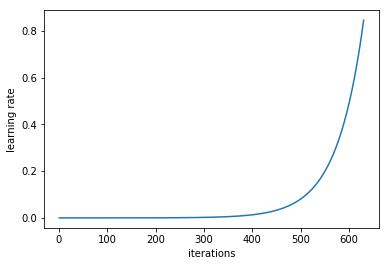

In [47]:
learn.sched.plot_lr()

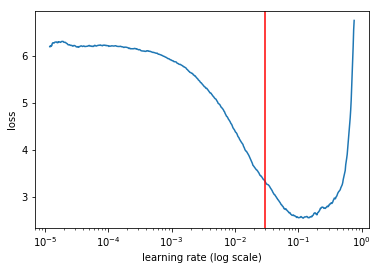

In [48]:
learn.sched.plot()
LEARN_RATE=3e-2
plt.axvline(x=LEARN_RATE, color="red");

In [49]:
learn.fit(LEARN_RATE, 1)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy                   
    0      1.203853   0.753666   0.810488  


In [50]:
learn.precompute=False
learn.fit(LEARN_RATE, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.958616   0.648889   0.838588  
    1      0.856612   0.624527   0.841366                    
    2      0.800968   0.608714   0.844143                    


[array([0.60871]), 0.8441431138994958]

In [51]:
learn.fit(LEARN_RATE, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.718783   0.591131   0.851005  
    1      0.737703   0.592521   0.850025                    


[array([0.59252]), 0.8500245058191814]

In [52]:
learn.unfreeze()
lr=np.array([LEARN_RATE//100,LEARN_RATE//10,LEARN_RATE])

In [53]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.818868   0.642941   0.839569  
    1      0.785882   0.623166   0.845123                    
    2      0.702673   0.626127   0.845613                    


[array([0.62613]), 0.8456134618623762]

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.715914   0.620476   0.846757  
    1      0.756287   0.619419   0.846104                    
    2      0.674982   0.591448   0.852475                    
    3      0.715587   0.632254   0.845123                    
    4      0.618912   0.614152   0.849371                    
    5      0.575641   0.599179   0.854599                    
    6      0.567453   0.605842   0.848554                    


[array([0.60584]), 0.8485541578465633]

In [55]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

In [56]:
learn.set_data(get_data(299, bs))

In [57]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.715511   0.582316   0.850841  
    1      0.631029   0.578544   0.848064                    
    2      0.517821   0.569571   0.851331                    
    3      0.612919   0.587182   0.854272                    
    4      0.530441   0.581956   0.855089                    
    5      0.538164   0.569159   0.860154                    
    6      0.464672   0.564791   0.860644                    


[array([0.56479]), 0.8606436856820135]

In [58]:
learn.save('299')

In [ ]:
learn.load('299')

In [60]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

0.8704460055546479

# Analyse results

In [61]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 13   0   0 ...   0   0   0]
 [  0  14   0 ...   0   0   1]
 [  0   0  28 ...   0   0   0]
 ...
 [  0   0   0 ...  15   0   0]
 [  0   0   0 ...   0  20   0]
 [  0   0   0 ...   0   0 141]]


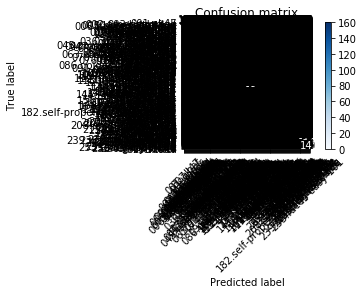

In [62]:
plot_confusion_matrix(cm, data.classes)

## Upload model to S3

In [64]:
def get_relative_path(filename):
    s1 = os.path.split(filename)
    p = os.path.split(s1[0])[1]
    return os.path.join(p, s1[1])

In [65]:
def create_dummy_data(src_path, dest_root, sub_dir, num_items=2):
    if not os.path.isdir(dest_root): os.mkdir(dest_root)
    dst_path = os.path.join(dest_root, sub_dir)
    classes = os.listdir(src_path)
    for d in classes:
        if d.startswith('.'): continue
        if not os.path.isdir(dst_path): os.mkdir(dst_path)
        if not os.path.isdir(os.path.join(dst_path, d)): os.mkdir(os.path.join(dst_path, d))
        fnames = glob('{}/{}/*.jpg'.format(src_path, d))
        for i in range(num_items):
            shutil.copyfile(fnames[i], os.path.join(dst_path, get_relative_path(fnames[i])))

In [67]:
create_dummy_data(PATH + "train", PATH + "models/data", "train")

In [68]:
!tar czvf data/caltech_256/model.tar.gz --exclude='tmp.h5' -C data/caltech_256/models/ .

./
./299.h5
./data/
./data/train/
./data/train/242.watermelon/
./data/train/242.watermelon/242_0056.jpg
./data/train/242.watermelon/242_0039.jpg
./data/train/119.jesus-christ/
./data/train/119.jesus-christ/119_0040.jpg
./data/train/119.jesus-christ/119_0067.jpg
./data/train/243.welding-mask/
./data/train/243.welding-mask/243_0039.jpg
./data/train/243.welding-mask/243_0050.jpg
./data/train/039.chopsticks/
./data/train/039.chopsticks/039_0038.jpg
./data/train/039.chopsticks/039_0044.jpg
./data/train/251.airplanes-101/
./data/train/251.airplanes-101/251_0590.jpg
./data/train/251.airplanes-101/251_0029.jpg
./data/train/084.giraffe/
./data/train/084.giraffe/084_0035.jpg
./data/train/084.giraffe/084_0056.jpg
./data/train/077.french-horn/
./data/train/077.french-horn/077_0041.jpg
./data/train/077.french-horn/077_0085.jpg
./data/train/206.sushi/
./data/train/206.sushi/206_0044.jpg
./data/train/206.sushi/206_0048.jpg
./data/train/045.computer-keyboard/
./data/train/045.computer-keyboard/045_002

./data/train/132.light-house/132_0090.jpg
./data/train/205.superman/
./data/train/205.superman/205_0045.jpg
./data/train/205.superman/205_0087.jpg
./data/train/130.license-plate/
./data/train/130.license-plate/130_0003.jpg
./data/train/130.license-plate/130_0035.jpg
./data/train/195.soda-can/
./data/train/195.soda-can/195_0062.jpg
./data/train/195.soda-can/195_0048.jpg
./data/train/102.helicopter-101/
./data/train/102.helicopter-101/102_0022.jpg
./data/train/102.helicopter-101/102_0018.jpg
./data/train/003.backpack/
./data/train/003.backpack/003_0029.jpg
./data/train/003.backpack/003_0093.jpg
./data/train/128.lathe/
./data/train/128.lathe/128_0045.jpg
./data/train/128.lathe/128_0046.jpg
./data/train/176.saddle/
./data/train/176.saddle/176_0097.jpg
./data/train/176.saddle/176_0015.jpg
./data/train/256.toad/
./data/train/256.toad/256_0068.jpg
./data/train/256.toad/256_0100.jpg
./data/train/081.frying-pan/
./data/train/081.frying-pan/081_0050.jpg
./data/train/081.frying-pan/081_0014.jpg
.

./data/train/189.snail/189_0001.jpg
./data/train/058.doorknob/
./data/train/058.doorknob/058_0009.jpg
./data/train/058.doorknob/058_0004.jpg
./data/train/055.dice/
./data/train/055.dice/055_0078.jpg
./data/train/055.dice/055_0051.jpg
./data/train/234.tweezer/
./data/train/234.tweezer/234_0096.jpg
./data/train/234.tweezer/234_0009.jpg
./data/train/033.cd/
./data/train/033.cd/033_0044.jpg
./data/train/033.cd/033_0081.jpg
./data/train/214.teepee/
./data/train/214.teepee/214_0075.jpg
./data/train/214.teepee/214_0079.jpg
./data/train/087.goldfish/
./data/train/087.goldfish/087_0020.jpg
./data/train/087.goldfish/087_0054.jpg
./data/train/239.washing-machine/
./data/train/239.washing-machine/239_0058.jpg
./data/train/239.washing-machine/239_0052.jpg
./data/train/229.tricycle/
./data/train/229.tricycle/229_0083.jpg
./data/train/229.tricycle/229_0094.jpg
./data/train/041.coffee-mug/
./data/train/041.coffee-mug/041_0082.jpg
./data/train/041.coffee-mug/041_0041.jpg
./data/train/079.frisbee/
./dat

./data/train/162.picnic-table/162_0047.jpg
./data/train/038.chimp/
./data/train/038.chimp/038_0092.jpg
./data/train/038.chimp/038_0069.jpg
./data/train/103.hibiscus/
./data/train/103.hibiscus/103_0070.jpg
./data/train/103.hibiscus/103_0076.jpg
./data/train/173.rifle/
./data/train/173.rifle/173_0010.jpg
./data/train/173.rifle/173_0080.jpg
./data/train/105.horse/
./data/train/105.horse/105_0227.jpg
./data/train/105.horse/105_0049.jpg
./data/train/230.trilobite-101/
./data/train/230.trilobite-101/230_0053.jpg
./data/train/230.trilobite-101/230_0074.jpg
./data/train/090.gorilla/
./data/train/090.gorilla/090_0143.jpg
./data/train/090.gorilla/090_0193.jpg
./data/train/157.pci-card/
./data/train/157.pci-card/157_0004.jpg
./data/train/157.pci-card/157_0012.jpg
./data/train/237.vcr/
./data/train/237.vcr/237_0024.jpg
./data/train/237.vcr/237_0027.jpg


In [71]:
import boto3

In [69]:
bucket='sagemaker-mcclean-eu-west-1'          # customize to the name of your S3 bucket
key='models/caltech256_fastai/model.tar.gz'   # prefix of the S3 bucket of the model file

In [ ]:
boto3.client('s3').upload_file(PATH+"model.tar.gz", bucket, key)
print(f"Uploaded model artefacts to s3://{bucket}/{key}")